In [ ]:
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('increasing_k_l.csv', header=None)

print(df.columns)

ks = df[0]

Int64Index([0, 1, 2, 3], dtype='int64')


In [ ]:
import torch
import json

task = 'clinic150'
root_dir = '.'
sims = torch.load(f"{root_dir}/sims/{task}-bge-large-en-v1.5-sims-e+p+om.pt", weights_only=True)
intents = open(f"{root_dir}/data/{task}/intents.txt").read().splitlines()
data = json.load(open(f"{root_dir}/data/{task}/data-full-shuffled.json"))['data']
labels = torch.tensor([intents.index(entry['intent']) for entry in data])

In [63]:
ranked_indices = torch.argsort(sims, dim=1, descending=True)
intent_loc = torch.argsort(ranked_indices, dim=1)
label_loc = torch.gather(intent_loc, dim=1, index=labels.reshape(-1, 1))

p_top_k = torch.tensor([(label_loc <= i).sum() for i in range(len(intents))])
p_top_k = (p_top_k / len(data))

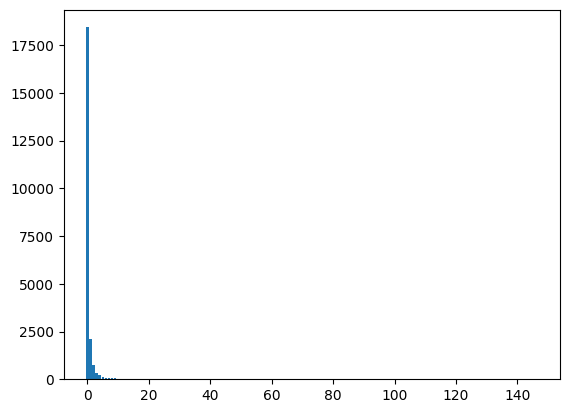

In [64]:
plt.bar(*torch.unique(label_loc, return_counts=True))
plt.show()

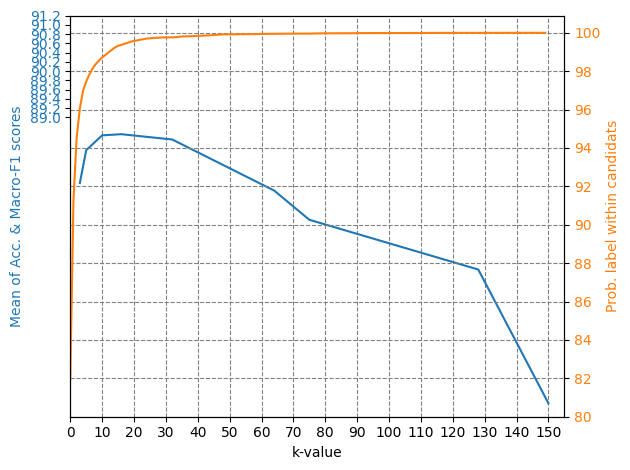

In [65]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('k-value')
ax1.set_ylabel('Mean of Acc. & Macro-F1 scores', color=color)
ax1.plot(ks.tolist(), df[3].tolist(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.yticks(np.arange(89, 91.2, step=0.2))
# plt.yticks(np.arange(80, 90, step=1.0))

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Prob. label within candidats', color=color)
ax2.plot(np.arange(len(intents)), p_top_k * 100, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlim([0, 155])
plt.xticks(np.arange(0, 160, step=10))

plt.yticks(np.arange(80, 102, step=2))

# ax1.set_ylim([89, 91])

ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax1.xaxis.grid(color='gray', linestyle='dashed')

fig.tight_layout()
plt.show()

In [66]:
error_rates_in_cand = []
for k in [3, 5, 10, 16, 32, 64, 75, 128, 151]:
    suffix = '' if k == 3 else f"_k{str(k)}"
    # model_outs = json.load(open(f"{root_dir}/results/gemma-2-9b-it/8_bit_quant{suffix}/clean/clinic150-gemma-2-9b-it.json"))
    model_outs = json.load(open(f"{root_dir}/results/Meta-Llama-3.1-8B-Instruct/8_bit_quant{suffix}/clean/clinic150-llama-3.1-8b-instruct.json"))
    model_outs = [entry['model_out'] for entry in model_outs]
    correct_pred = torch.tensor([int(model_outs[i] in intents and intents.index(model_outs[i]) == labels[i]) for i in range(len(model_outs))])

    pred_correct_in_cand = correct_pred[(label_loc <= k).nonzero()]
    error_rates_in_cand.append(pred_correct_in_cand.float().mean())

error_rates_in_cand = torch.tensor(error_rates_in_cand)

In [67]:
error_rates_in_cand

tensor([0.9569, 0.9537, 0.9493, 0.9453, 0.9425, 0.9378, 0.9347, 0.9291, 0.9332])

In [ ]:
for i in error_rates_in_cand:
    print(f"{(i.item()* 100):.4f}")

0.96
0.95
0.95
0.95
0.94
0.94
0.93
0.93
0.93


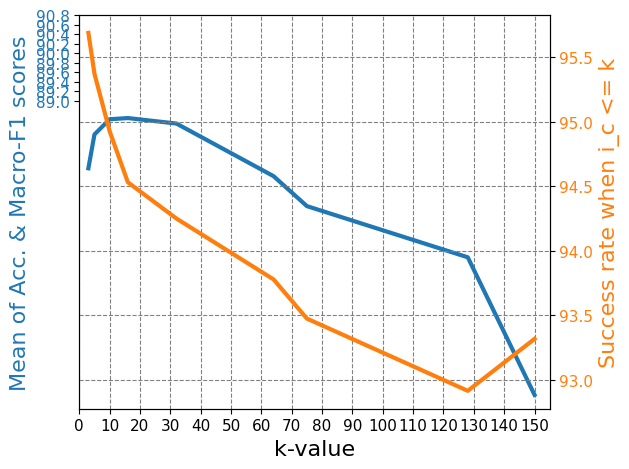

In [79]:
fig, ax1 = plt.subplots()
color = 'tab:blue'

fontsize = 24
ax1.set_xlabel('k-value', fontdict={'fontsize': 16})
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_ylabel('Mean of Acc. & Macro-F1 scores', color=color, fontdict={'fontsize': 16})
ax1.plot(ks.tolist(), df[3].tolist(), color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)

plt.yticks(np.arange(89, 91, step=0.2))
# plt.yticks(np.arange(81, 91, step=1.0))

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Success rate when i_c <= k', color=color, fontdict={'fontsize': 16})
ax2.plot(ks.tolist(), error_rates_in_cand * 100, color=color, linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax1.set_xlim([0, 155])
plt.xticks(np.arange(0, 160, step=10))

# plt.yticks(np.arange(94, 97.2, step=0.5))

# ax1.set_ylim([89, 91])

ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax1.xaxis.grid(color='gray', linestyle='dashed')

fig.tight_layout()
plt.show()

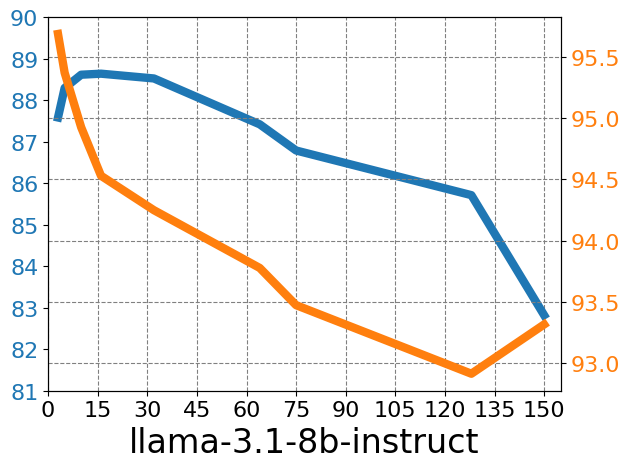

In [80]:
# model = 'gemma-2-9b-it'
model = 'llama-3.1-8b-instruct'

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel(f"{model}", fontdict={'fontsize': 24})
ax1.tick_params(axis='both', which='major')
# ax1.set_ylabel('Mean Acc. & F1', color=color, fontdict={'fontsize': 16})
ax1.plot(ks.tolist(), df[3].tolist(), color=color, linewidth=6)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
ax1.tick_params(axis='x', labelsize=16)

# plt.yticks(np.arange(89, 91, step=0.2))
plt.yticks(np.arange(81, 91, step=1.0))

ax2 = ax1.twinx()

color = 'tab:orange'
# ax2.set_ylabel('Success rate', color=color, fontdict={'fontsize': 16})
ax2.plot(ks.tolist(), error_rates_in_cand * 100, color=color, linewidth=6)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)
ax2.tick_params(axis='both', which='major')
ax1.set_xlim([0, 155])
plt.xticks(np.arange(0, 160, step=15))

# plt.yticks(np.arange(94, 97.2, step=0.5))

# ax1.set_ylim([89, 91])

ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax1.xaxis.grid(color='gray', linestyle='dashed')

fig.tight_layout()
plt.show()

<!-- ### Graph p-top-k for both models -->

In [71]:
# Load data
df_g = pd.read_csv('increasing_k_g.csv', header=None)
df_l = pd.read_csv('increasing_k_l.csv', header=None)
ks = df_g[0]

In [ ]:
import torch
import json

def get_p_top_k(encoder_model, embeddings):
    task = 'clinic150'
    root_dir = '.'
    sims = torch.load(f"{root_dir}/sims/{task}-{encoder_model}-sims-{embeddings}.pt", weights_only=True)
    intents = open(f"{root_dir}/data/{task}/intents.txt").read().splitlines()
    data = json.load(open(f"{root_dir}/data/{task}/data-full-shuffled.json"))['data']
    labels = torch.tensor([intents.index(entry['intent']) for entry in data])

    ranked_indices = torch.argsort(sims, dim=1, descending=True)
    intent_loc = torch.argsort(ranked_indices, dim=1)
    label_loc = torch.gather(intent_loc, dim=1, index=labels.reshape(-1, 1)).flatten()

    p_top_k = torch.tensor([(label_loc <= i).sum() for i in range(len(intents))])
    p_top_k = (p_top_k / len(data))
    return p_top_k, label_loc

In [73]:
select_range = 40
p_top_k_bge, label_loc_bge = get_p_top_k('bge-large-en-v1.5', 'e+p+om')
p_top_k_bge_e, label_loc_bge_e = get_p_top_k('bge-large-en-v1.5', 'e')
p_top_k_gte, label_loc_gte = get_p_top_k('gte-large', 'e+p+om')
p_top_k_gte_e, label_loc_gte_e = get_p_top_k('gte-large', 'e')

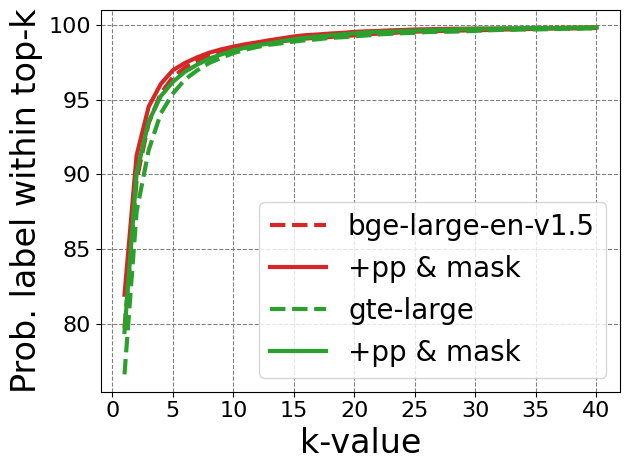

In [74]:
fig, ax1 = plt.subplots()
color = 'tab:red'

xticks = np.arange(select_range) + 1
linewidth = 3

ax1.set_xlabel('k-value', fontdict={'fontsize': 24})
ax1.set_ylabel('Prob. label within top-k', fontdict={'fontsize': 24})
ax1.plot(xticks, p_top_k_bge_e[:select_range] * 100, color=color, linewidth=linewidth, linestyle='dashed', label='bge-large-en-v1.5')
ax1.plot(xticks, p_top_k_bge[:select_range] * 100, color=color, linewidth=linewidth, label='+pp & mask')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

color = 'tab:green'
ax1.plot(xticks, p_top_k_gte_e[:select_range] * 100, color=color, linewidth=linewidth, linestyle='dashed', label='gte-large')
ax1.plot(np.arange(select_range) + 1, p_top_k_gte[:select_range] * 100, color=color, linewidth=linewidth, label='+pp & mask')

x_step_size = 5
plt.xticks(np.arange(0, select_range + x_step_size, step=x_step_size))
# plt.yticks(np.arange(80, 102, step=2))

# ax1.set_ylim([90, 100])

ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax1.xaxis.grid(color='gray', linestyle='dashed')

fig.tight_layout()
plt.legend(prop={'size': 20})
plt.show()

In [75]:
print("Print success rate at k=5")
print(p_top_k_bge[4])
print(p_top_k_bge_e[4])
print(p_top_k_gte[4])
print(p_top_k_gte_e[4])
print()

print("Rate at which p+om ranked higher than e")
top_5_bge = (label_loc_bge_e < 5).nonzero().flatten()
top_5_gte = (label_loc_gte_e < 5).nonzero().flatten()

print((label_loc_bge > label_loc_bge_e).float().mean())
print((label_loc_bge < label_loc_bge_e).float().mean())
print((label_loc_gte > label_loc_gte_e).float().mean())
print((label_loc_gte < label_loc_gte_e).float().mean())
print()
print((label_loc_bge[top_5_bge] > label_loc_bge_e[top_5_bge]).float().mean())
print((label_loc_bge[top_5_bge] < label_loc_bge_e[top_5_bge]).float().mean())
print((label_loc_gte[top_5_gte] > label_loc_gte_e[top_5_gte]).float().mean())
print((label_loc_gte[top_5_gte] < label_loc_gte_e[top_5_gte]).float().mean())
print()
print(((label_loc_bge[top_5_bge] > label_loc_bge_e[top_5_bge]) & (label_loc_bge[top_5_bge] >= 5)).float().mean())
print(((label_loc_gte[top_5_gte] > label_loc_gte_e[top_5_gte]) & (label_loc_gte[top_5_gte] >= 5)).float().mean())
print()

Print success rate at k=5
tensor(0.9698)
tensor(0.9652)
tensor(0.9620)
tensor(0.9541)

Rate at which p+om ranked higher than e
tensor(0.0628)
tensor(0.0987)
tensor(0.0669)
tensor(0.1160)

tensor(0.0565)
tensor(0.0769)
tensor(0.0579)
tensor(0.0893)

tensor(0.0091)
tensor(0.0096)



In [76]:
torch.unique(label_loc_bge_e, return_counts=True)

(tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  55,  56,
          61,  62,  65,  66,  67,  68,  70,  71,  75,  77,  88,  90,  98, 102,
         103, 105, 145]),
 tensor([17933,  2237,   855,   443,   248,   145,    96,    77,    50,    40,
            42,    43,    19,    28,    20,    21,    12,    11,    14,    11,
            17,     8,    10,    11,     9,     4,     6,     6,     2,     3,
             4,     7,     2,     4,     5,     3,     1,     1,     4,     3,
             1,     1,     1,     2,     1,     1,     2,     1,     2,     2,
             1,     1,     1,     1,     2,     3,     1,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     2,     3,     2,     1,
             1,     1,    

# Different investigation into k=150 prediction characteristics

In [ ]:
import os
import pandas as pd

from tqdm import tqdm
from utils import load_data, MODEL_TO_NAME

root_dir = ''

tasks = [
    'atis',
    'snips',
    'clinic150',
    'massive'
]

models = [
    'llama-3.1-8b-instruct',
    'gemma-2-9b-it',
    'phi-3-medium-4k-instruct',
    'mistral-7b-instruct'
]

In [78]:
model_outputs = []
quant = '8_bit_quant_k151'
for model_type in tqdm(models):
    model_entry = {'model': model_type}
    model_name = MODEL_TO_NAME[model_type]
    for task in tasks:
        if os.path.exists(f"{root_dir}/results/{model_name}/{quant}"):
            _, preds, _, _, _ = load_data(task, model_type, model_name, quant)
            failue_rate = (preds == -1).float().mean().item()
            model_entry[f"{task}-fr"] = failue_rate

    model_outputs.append(model_entry)

model_outputs = pd.DataFrame(model_outputs)
model_outputs.to_excel("increasing_k151_fr.xlsx", index=False)

100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
